In [ ]:
# tune_optuna_bilstm_wind.py
import argparse, json, math, random
from pathlib import Path

import numpy as np
import optuna
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt

# ======= Columns =======
TIME_COL   = "TIMESTAMP"
TARGET_COL = "TARGETVAR"
BASE_FEATS = ["U10", "V10", "U100", "V100"]

# ======= Fixed FE (same as your script) =======
LAGS_Y     = [1, 3, 6, 12, 24]
LAGS_SPEED = [1, 3, 6]
ROLLS_Y    = [6, 12, 24]

# ======= Splits =======
TRAIN_RATIO = 0.70
VAL_RATIO   = 0.15  # Test = rest (≈ 0.15)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ======= Repro =======
def set_seed(seed: int):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

# ======= FE =======
def add_engineered_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create new features out of the existing data 
    - Calculate the resultant wind speed and the resultant direction in sine and cosine terms
    - Caluclate the difference between the wind speeds at the two heights and get the angle difference too 
    - get the time values for seasonal and repititive features and convert it to sine and cos terms
    """
    out = df.copy()
    # wind speed & direction
    out["speed10"]  = np.sqrt(out["U10"]**2  + out["V10"]**2)
    out["speed100"] = np.sqrt(out["U100"]**2 + out["V100"]**2)
    dir10  = np.arctan2(out["V10"],  out["U10"])
    dir100 = np.arctan2(out["V100"], out["U100"])
    out["dir10_sin"], out["dir10_cos"]   = np.sin(dir10),  np.cos(dir10)
    out["dir100_sin"], out["dir100_cos"] = np.sin(dir100), np.cos(dir100)

    # shear & veer
    out["shear_speed"] = out["speed100"] - out["speed10"]
    veer = dir100 - dir10
    out["veer_sin"], out["veer_cos"] = np.sin(veer), np.cos(veer)

    # time features
    out["hour"] = out[TIME_COL].dt.hour
    out["day"]  = out[TIME_COL].dt.dayofyear
    out["hour_sin"] = np.sin(2*np.pi*out["hour"]/24.0)
    out["hour_cos"] = np.cos(2*np.pi*out["hour"]/24.0)
    out["day_sin"]  = np.sin(2*np.pi*out["day"]/366.0)
    out["day_cos"]  = np.cos(2*np.pi*out["day"]/366.0)

    # target lags (shifted)
    for L in LAGS_Y:
        out[f"y_lag{L}"] = out[TARGET_COL].shift(L)
    # rolling means of y (shift to avoid leakage)
    for W in ROLLS_Y:
        out[f"y_roll{W}"] = out[TARGET_COL].shift(1).rolling(W, min_periods=W).mean()
    # speed lags
    for L in LAGS_SPEED:
        out[f"speed10_lag{L}"]  = out["speed10"].shift(L)
        out[f"speed100_lag{L}"] = out["speed100"].shift(L)
    return out

def build_feat_list():
    """
    Create a  list of all the feature columns used to train the machine learning model
    Target values are also included in the dataset in specific time intervals.
    """
    return (
        BASE_FEATS +
        ["speed10","speed100","dir10_sin","dir10_cos","dir100_sin","dir100_cos",
         "shear_speed","veer_sin","veer_cos","hour_sin","hour_cos","day_sin","day_cos"] +
        [f"y_lag{L}" for L in LAGS_Y] +
        [f"y_roll{W}" for W in ROLLS_Y] +
        [f"speed10_lag{L}" for L in LAGS_SPEED] +
        [f"speed100_lag{L}" for L in LAGS_SPEED]
    )

# ======= Data I/O =======
def load_data(file_path: str, sheet: str) -> pd.DataFrame:
    "Read the dataset"
    df = pd.read_excel("WindPowerForecastingData.xlsx")
    df[TIME_COL] = pd.to_datetime(df[TIME_COL], infer_datetime_format=True, errors="coerce")
    df = df.sort_values(TIME_COL).reset_index(drop=True)
    return df

def smape(y_true, y_pred, eps=1e-8):
    "Symmetric mean absolute error. good for small scale data"
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return 100.0 * np.mean(2.0 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + eps))

# ======= Sequences / Dataset =======
def make_sequences(X, y, lookback):
    "create the lists of data for training and testing"
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i-lookback:i, :])
        ys.append(y[i, 0])
    return np.array(Xs, np.float32), np.array(ys, np.float32).reshape(-1,1)

class SeqDS(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

# ======= Model =======
class BiLSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, bidirectional=True):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers>1 else 0.0,
            bidirectional=bidirectional
        )
        out_size = hidden_size * (2 if bidirectional else 1)
        self.norm = nn.LayerNorm(out_size)
        self.head = nn.Sequential(
            nn.Linear(out_size, out_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(out_size, 1),
        )
    def forward(self, x):
        o, _ = self.lstm(x)
        last = o[:, -1, :]
        last = self.norm(last)
        return self.head(last)

# ======= Fold training (returns Val RMSE in original units) =======
def train_fold(Xtr, ytr, Xva, yva, params, max_epochs, es_patience, log_target, clip_norm):
    # scalers fit on train only
    xsc = StandardScaler().fit(Xtr)
    ysc = StandardScaler().fit(ytr)
    Xtr_s, ytr_s = xsc.transform(Xtr), ysc.transform(ytr)
    Xva_s, yva_s = xsc.transform(Xva), ysc.transform(yva)

    # sequences
    lookback = params["lookback"]
    Xtr_seq, ytr_seq = make_sequences(Xtr_s, ytr_s, lookback)
    Xva_seq, yva_seq = make_sequences(Xva_s, yva_s, lookback)

    if len(Xtr_seq) < 16 or len(Xva_seq) < 16:
        return float("inf"), None, None  # degenerate

    tr_loader = DataLoader(SeqDS(Xtr_seq, ytr_seq), batch_size=params["batch"], shuffle=True)
    va_loader = DataLoader(SeqDS(Xva_seq, yva_seq), batch_size=params["batch"], shuffle=False)

    model = BiLSTMRegressor(
        input_size=Xtr_seq.shape[-1],
        hidden_size=params["hidden"],
        num_layers=params["layers"],
        dropout=params["dropout"],
        bidirectional=params["bidir"]
    ).to(DEVICE)

    loss_fn = nn.SmoothL1Loss(beta=0.5)
    opt = torch.optim.Adam(model.parameters(), lr=params["lr"], weight_decay=params["wd"])
    # cosine warm restarts works well for seq models
    sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=10, T_mult=2, eta_min=1e-5)

    def inv_target(y_scaled):
        y = ysc.inverse_transform(y_scaled).ravel()
        if log_target:
            y = np.expm1(y)
        return y

    best = float("inf"); no_improve = 0; best_state = None
    for epoch in range(1, max_epochs+1):
        model.train()
        for xb, yb in tr_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            if clip_norm is not None:
                nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
            opt.step()
        sched.step(epoch-1)

        # compute Val RMSE in original units
        model.eval()
        preds_s, trues_s = [], []
        with torch.no_grad():
            for xb, yb in va_loader:
                pr = model(xb.to(DEVICE)).cpu().numpy()
                preds_s.append(pr); trues_s.append(yb.numpy())
        preds_s = np.vstack(preds_s); trues_s = np.vstack(trues_s)
        y_pred = inv_target(preds_s)
        y_true = inv_target(trues_s)
        rmse = math.sqrt(mean_squared_error(y_true, y_pred))

        if rmse < best - 1e-6:
            best = rmse; no_improve = 0; best_state = model.state_dict()
        else:
            no_improve += 1
            if no_improve >= es_patience:
                break

    return best, best_state, (xsc, ysc)

# ======= Walk-forward CV (on Train+Val region; Test held out) =======
def make_walkforward_indices(n_total, n_test):
    """
    Reserve last n_test for final Test.
    Create 3 CV folds on the preceding region with growing Train, small Val windows.
    """
    n_tv = n_total - n_test
    # folds: [0:0.60->0.75], [0:0.75->0.85], [0:0.85->0.95] of the train+val region
    cut1 = int(n_tv * 0.60); val1 = int(n_tv * 0.75)
    cut2 = int(n_tv * 0.75); val2 = int(n_tv * 0.85)
    cut3 = int(n_tv * 0.85); val3 = int(n_tv * 0.95)

    folds = [
        (0, cut1, cut1, val1),
        (0, cut2, cut2, val2),
        (0, cut3, cut3, val3),
    ]
    return folds, n_tv

# ======= Objective for Optuna =======
def objective(trial, df: pd.DataFrame, max_epochs: int, es_patience: int):
    # search space
    params = {
        "lookback": trial.suggest_categorical("lookback", [12, 24, 36]),
        "hidden":   trial.suggest_categorical("hidden",   [64, 128]),
        "layers":   trial.suggest_categorical("layers",   [1, 2, 3]),
        "dropout":  trial.suggest_categorical("dropout", [0.1,0.2,0.3]),
        "bidir":    trial.suggest_categorical("bidir",    [True, False]),
        "batch":    trial.suggest_categorical("batch",    [64, 128]),
        "lr":       trial.suggest_categorical("lr", [1e-4, 1e-3]),
        "wd":       trial.suggest_categorical("weight_decay", [0.0,1e-4, 1e-3]),
        "clip":     trial.suggest_categorical("clip_norm", [None, 0.5, 1.0]),
        "log_target": trial.suggest_categorical("log_target", [False, True]),
    }

    # feature engineering + target transform (depends on LOG_TARGET)
    dfe = add_engineered_features(df)
    if params["log_target"]:
        dfe["_y"] = np.log1p(dfe[TARGET_COL].clip(lower=0)).astype(np.float32)
    else:
        dfe["_y"] = dfe[TARGET_COL].astype(np.float32)
    dfe = dfe.dropna().reset_index(drop=True)

    feat_cols = build_feat_list()
    X_all = dfe[feat_cols].to_numpy(np.float32)
    y_all = dfe[["_y"]].to_numpy(np.float32)

    n_total = len(dfe)
    n_test  = int(len(dfe) * (1 - (TRAIN_RATIO + VAL_RATIO)))  # ≈ last 15% kept for final test
    folds, n_tv = make_walkforward_indices(n_total, n_test)

    fold_rmses = []
    for (tr_start, tr_end, va_start, va_end) in folds:
        Xtr = X_all[tr_start:tr_end]; ytr = y_all[tr_start:tr_end]
        Xva = X_all[va_start:va_end]; yva = y_all[va_start:va_end]
        rmse, _, _ = train_fold(Xtr, ytr, Xva, yva,
                                params=params,
                                max_epochs=max_epochs,
                                es_patience=es_patience,
                                log_target=params["log_target"],
                                clip_norm=params["clip"])
        fold_rmses.append(rmse)

    avg_rmse = float(np.mean(fold_rmses))
    trial.set_user_attr("fold_rmses", fold_rmses)
    return avg_rmse

# ======= Final train on Train+Val, test on Test =======
def final_fit_and_test(df, best_params, max_epochs, es_patience, outdir: Path):
    dfe = add_engineered_features(df)
    if best_params["log_target"]:
        dfe["_y"] = np.log1p(dfe[TARGET_COL].clip(lower=0)).astype(np.float32)
    else:
        dfe["_y"] = dfe[TARGET_COL].astype(np.float32)
    dfe = dfe.dropna().reset_index(drop=True)

    feat_cols = build_feat_list()
    X_all = dfe[feat_cols].to_numpy(np.float32)
    y_all = dfe[["_y"]].to_numpy(np.float32)

    n_total = len(dfe)
    n_test  = int(len(dfe) * (1 - (TRAIN_RATIO + VAL_RATIO)))
    n_tv    = n_total - n_test

    X_trval, y_trval = X_all[:n_tv], y_all[:n_tv]
    X_test,  y_test  = X_all[n_tv:], y_all[n_tv:]

    # scalers on Train+Val
    xsc = StandardScaler().fit(X_trval)
    ysc = StandardScaler().fit(y_trval)
    Xtrv_s, ytrv_s = xsc.transform(X_trval), ysc.transform(y_trval)
    Xte_s,  yte_s  = xsc.transform(X_test),  ysc.transform(y_test)

    # sequences
    lookback = best_params["lookback"]
    Xtrv_seq, ytrv_seq = make_sequences(Xtrv_s, ytrv_s, lookback)
    Xte_seq,  yte_seq  = make_sequences(Xte_s,  yte_s,  lookback)

    tr_loader = DataLoader(SeqDS(Xtrv_seq, ytrv_seq), batch_size=best_params["batch"], shuffle=True)
    te_loader = DataLoader(SeqDS(Xte_seq,  yte_seq ), batch_size=best_params["batch"], shuffle=False)

    model = BiLSTMRegressor(
        input_size=Xtrv_seq.shape[-1],
        hidden_size=best_params["hidden"],
        num_layers=best_params["layers"],
        dropout=best_params["dropout"],
        bidirectional=best_params["bidir"]
    ).to(DEVICE)
    loss_fn = nn.SmoothL1Loss(beta=0.5)
    opt = torch.optim.Adam(model.parameters(), lr=best_params["lr"], weight_decay=best_params["wd"])
    sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=10, T_mult=2, eta_min=1e-5)

    best = float("inf"); no_improve = 0; best_state = None
    for epoch in range(1, max_epochs+1):
        model.train()
        for xb, yb in tr_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            if best_params["clip"] is not None:
                nn.utils.clip_grad_norm_(model.parameters(), best_params["clip"])
            opt.step()
        sched.step(epoch-1)

        # quick es on a random slice of tr_loader (optional)
        # here we skip extra val, and just run full epochs for stability

    # Evaluate on TEST in original units
    def inv_target(y_scaled):
        ys = ysc.inverse_transform(y_scaled).ravel()
        if best_params["log_target"]:
            ys = np.expm1(ys)
        return ys

    model.eval()
    preds_s, trues_s = [], []
    with torch.no_grad():
        for xb, yb in te_loader:
            pr = model(xb.to(DEVICE)).cpu().numpy()
            preds_s.append(pr); trues_s.append(yb.numpy())
    preds_s = np.vstack(preds_s); trues_s = np.vstack(trues_s)
    y_pred = inv_target(preds_s)
    y_true = inv_target(trues_s)

    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    smp  = smape(y_true, y_pred)

    # Save artifacts
    torch.save(model.state_dict(), outdir / "biLSTM/bilstm_optuna_best.pt")
    joblib.dump(xsc, outdir / "biLSTM/x_scaler_optuna.pkl")
    joblib.dump(ysc, outdir / "biLSTM/y_scaler_optuna.pkl")
    with open(outdir / "best_params.json", "w") as f:
        json.dump(best_params, f, indent=2)

    plt.figure(figsize=(12,5))
    plt.plot(y_true, label="Actual")
    plt.plot(y_pred, label="Pred (best Optuna)")
    plt.title("BiLSTM + FE — Test (Optuna best)")
    plt.xlabel("Test time steps"); plt.ylabel(TARGET_COL)
    plt.legend(); plt.tight_layout()
    plt.savefig(outdir / "biLSTM/test_plot_optuna.png", dpi=150)

    print("\n==== TEST (Optuna best) ====")
    print(f"RMSE : {rmse:.6f}\nMAE  : {mae:.6f}\nR^2  : {r2:.6f}\nsMAPE: {smp:.2f}%")
    print(f"Saved to: {outdir.resolve()}")

# ======= CLI =======
def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("--file",   type=str, required=True)
    ap.add_argument("--sheet",  type=str, default="WindPowerForecastingData")
    ap.add_argument("--trials", type=int, default=30)
    ap.add_argument("--timeout", type=int, default=None, help="Seconds budget (optional)")
    ap.add_argument("--epochs", type=int, default=80)
    ap.add_argument("--patience", type=int, default=12)
    ap.add_argument("--seed",  type=int, default=42)
    ap.add_argument("--outdir", type=str, default=".")
    args = ap.parse_args()

    set_seed(args.seed)
    outdir = Path(args.outdir); outdir.mkdir(parents=True, exist_ok=True)

    df = load_data(args.file, args.sheet)

    study = optuna.create_study(direction="minimize")
    study.optimize(
        lambda tr: objective(tr, df=df, max_epochs=args.epochs, es_patience=args.patience),
        n_trials=args.trials,
        timeout=args.timeout,
        show_progress_bar=True,
        gc_after_trial=True
    )

    print("\n==== OPTUNA BEST ====")
    print("Value (avg Val RMSE):", study.best_value)
    print("Params:", study.best_params)
    # coerce types (optuna may return None for clip_norm)
    best_params = {
        "lookback": study.best_params["lookback"],
        "hidden":   study.best_params["hidden"],
        "layers":   study.best_params["layers"],
        "dropout":  float(study.best_params["dropout"]),
        "bidir":    bool(study.best_params["bidir"]),
        "batch":    study.best_params["batch"],
        "lr":       float(study.best_params["lr"]),
        "wd":       float(study.best_params["weight_decay"]),
        "clip":     study.best_params["clip_norm"] if study.best_params["clip_norm"] is not None else None,
        "log_target": bool(study.best_params["log_target"]),
    }

    # Final train on Train+Val, test on Test
    final_fit_and_test(df, best_params, args.epochs, args.patience, outdir)

# ======= helper metrics used above =======
def mean_squared_error(y_true, y_pred):
    return np.mean((np.asarray(y_true) - np.asarray(y_pred))**2)

if __name__ == "__main__":
    main()


/tmp/ipykernel_45229/1256285189.py:92: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[TIME_COL] = pd.to_datetime(df[TIME_COL], infer_datetime_format=True, errors="coerce")
[I 2025-09-17 21:53:39,546] A new study created in memory with name: no-name-0492eb28-9531-49b6-9bf2-c1f7777ad75c
  0%|          | 0/30 [03:54<?, ?it/s]

[I 2025-09-17 21:57:34,067] Trial 0 finished with value: 0.11704609212539913 and parameters: {'lookback': 24, 'hidden': 64, 'layers': 1, 'dropout': 0.1, 'bidir': False, 'batch': 256, 'lr': 0.0001518805146235236, 'weight_decay': 0.001, 'clip_norm': 0.5, 'log_target': False}. Best is trial 0 with value: 0.11704609212539913.


Best trial: 0. Best value: 0.117046:   3%|▎         | 1/30 [14:19<1:53:30, 234.83s/it]

[I 2025-09-17 22:07:59,004] Trial 1 finished with value: 0.11528920023206396 and parameters: {'lookback': 36, 'hidden': 128, 'layers': 2, 'dropout': 0.30000000000000004, 'bidir': False, 'batch': 64, 'lr': 0.0015610573356787416, 'weight_decay': 0.001, 'clip_norm': 0.5, 'log_target': True}. Best is trial 1 with value: 0.11528920023206396.


Best trial: 1. Best value: 0.115289:   7%|▋         | 2/30 [2:09:52<3:36:39, 464.28s/it]

[I 2025-09-18 00:03:31,579] Trial 2 finished with value: 0.1176663424255151 and parameters: {'lookback': 48, 'hidden': 128, 'layers': 3, 'dropout': 0.4, 'bidir': True, 'batch': 256, 'lr': 0.0001629352534156703, 'weight_decay': 1e-05, 'clip_norm': 0.5, 'log_target': False}. Best is trial 1 with value: 0.11528920023206396.


Best trial: 1. Best value: 0.115289:  10%|█         | 3/30 [3:30:42<25:38:01, 3417.83s/it]

[I 2025-09-18 01:24:21,714] Trial 3 finished with value: 0.1158359583596185 and parameters: {'lookback': 48, 'hidden': 128, 'layers': 3, 'dropout': 0.1, 'bidir': True, 'batch': 128, 'lr': 0.0012922639493612614, 'weight_decay': 0.001, 'clip_norm': None, 'log_target': True}. Best is trial 1 with value: 0.11528920023206396.


Best trial: 1. Best value: 0.115289:  13%|█▎        | 4/30 [3:45:49<28:46:05, 3983.28s/it]

[I 2025-09-18 01:39:29,327] Trial 4 finished with value: 0.12217745703278089 and parameters: {'lookback': 24, 'hidden': 64, 'layers': 3, 'dropout': 0.4, 'bidir': False, 'batch': 256, 'lr': 0.00011282451950190299, 'weight_decay': 0.0, 'clip_norm': 2.0, 'log_target': True}. Best is trial 1 with value: 0.11528920023206396.


Best trial: 1. Best value: 0.115289:  17%|█▋        | 5/30 [3:52:28<19:57:34, 2874.17s/it]

[I 2025-09-18 01:46:07,626] Trial 5 finished with value: 0.1158604775753657 and parameters: {'lookback': 36, 'hidden': 64, 'layers': 2, 'dropout': 0.1, 'bidir': True, 'batch': 64, 'lr': 0.0006616797668970049, 'weight_decay': 0.0001, 'clip_norm': None, 'log_target': False}. Best is trial 1 with value: 0.11528920023206396.


Best trial: 1. Best value: 0.115289:  20%|██        | 6/30 [4:01:37<13:32:57, 2032.38s/it]

[I 2025-09-18 01:55:17,424] Trial 6 finished with value: 0.11790346848123957 and parameters: {'lookback': 48, 'hidden': 64, 'layers': 3, 'dropout': 0.0, 'bidir': False, 'batch': 128, 'lr': 0.00039595387760974995, 'weight_decay': 0.001, 'clip_norm': None, 'log_target': True}. Best is trial 1 with value: 0.11528920023206396.


Best trial: 1. Best value: 0.115289:  23%|██▎       | 7/30 [4:03:58<9:53:16, 1547.68s/it] 

[I 2025-09-18 01:57:38,078] Trial 7 finished with value: 0.11661589530989384 and parameters: {'lookback': 24, 'hidden': 128, 'layers': 1, 'dropout': 0.0, 'bidir': False, 'batch': 256, 'lr': 0.0009750120000055385, 'weight_decay': 0.0, 'clip_norm': None, 'log_target': False}. Best is trial 1 with value: 0.11528920023206396.


Best trial: 1. Best value: 0.115289:  27%|██▋       | 8/30 [4:17:35<6:43:14, 1099.75s/it]

[I 2025-09-18 02:11:15,327] Trial 8 finished with value: 0.11570120016374426 and parameters: {'lookback': 48, 'hidden': 128, 'layers': 2, 'dropout': 0.5, 'bidir': False, 'batch': 128, 'lr': 0.0021629482937817607, 'weight_decay': 1e-05, 'clip_norm': 2.0, 'log_target': True}. Best is trial 1 with value: 0.11528920023206396.


Best trial: 1. Best value: 0.115289:  30%|███       | 9/30 [4:24:33<5:54:00, 1011.44s/it]

[I 2025-09-18 02:18:13,088] Trial 9 finished with value: 0.11733408225113943 and parameters: {'lookback': 12, 'hidden': 64, 'layers': 3, 'dropout': 0.0, 'bidir': True, 'batch': 64, 'lr': 0.0002384772787511612, 'weight_decay': 0.001, 'clip_norm': None, 'log_target': True}. Best is trial 1 with value: 0.11528920023206396.


Best trial: 1. Best value: 0.115289:  33%|███▎      | 10/30 [4:31:05<4:36:03, 828.16s/it]

[I 2025-09-18 02:24:45,312] Trial 10 finished with value: 0.11487688457760065 and parameters: {'lookback': 36, 'hidden': 128, 'layers': 2, 'dropout': 0.30000000000000004, 'bidir': False, 'batch': 64, 'lr': 0.0027859626563641084, 'weight_decay': 0.0001, 'clip_norm': 1.0, 'log_target': True}. Best is trial 10 with value: 0.11487688457760065.


Best trial: 10. Best value: 0.114877:  37%|███▋      | 11/30 [4:37:38<3:40:00, 694.74s/it]

[I 2025-09-18 02:31:18,491] Trial 11 finished with value: 0.1157522432817134 and parameters: {'lookback': 36, 'hidden': 128, 'layers': 2, 'dropout': 0.30000000000000004, 'bidir': False, 'batch': 64, 'lr': 0.002826970274570321, 'weight_decay': 0.0001, 'clip_norm': 1.0, 'log_target': True}. Best is trial 10 with value: 0.11487688457760065.


Best trial: 10. Best value: 0.114877:  40%|████      | 12/30 [4:44:30<3:00:54, 603.00s/it]

[I 2025-09-18 02:38:10,176] Trial 12 finished with value: 0.11507672464990049 and parameters: {'lookback': 36, 'hidden': 128, 'layers': 2, 'dropout': 0.30000000000000004, 'bidir': False, 'batch': 64, 'lr': 0.0017204949112202361, 'weight_decay': 0.0001, 'clip_norm': 1.0, 'log_target': True}. Best is trial 10 with value: 0.11487688457760065.


Best trial: 10. Best value: 0.114877:  43%|████▎     | 13/30 [4:51:02<2:34:25, 545.05s/it]

[I 2025-09-18 02:44:42,142] Trial 13 finished with value: 0.1148973466758898 and parameters: {'lookback': 36, 'hidden': 128, 'layers': 2, 'dropout': 0.2, 'bidir': False, 'batch': 64, 'lr': 0.002968394076714632, 'weight_decay': 0.0001, 'clip_norm': 1.0, 'log_target': True}. Best is trial 10 with value: 0.11487688457760065.


Best trial: 10. Best value: 0.114877:  47%|████▋     | 14/30 [4:58:08<2:13:00, 498.81s/it]

[I 2025-09-18 02:51:47,646] Trial 14 finished with value: 0.11534146661058774 and parameters: {'lookback': 36, 'hidden': 128, 'layers': 2, 'dropout': 0.2, 'bidir': False, 'batch': 64, 'lr': 0.0027982853288301113, 'weight_decay': 0.0001, 'clip_norm': 1.0, 'log_target': True}. Best is trial 10 with value: 0.11487688457760065.


Best trial: 10. Best value: 0.114877:  50%|█████     | 15/30 [5:01:45<1:59:10, 476.71s/it]

[I 2025-09-18 02:55:25,482] Trial 15 finished with value: 0.11560073082878349 and parameters: {'lookback': 12, 'hidden': 128, 'layers': 2, 'dropout': 0.2, 'bidir': False, 'batch': 64, 'lr': 0.0007904902373149437, 'weight_decay': 0.0001, 'clip_norm': 1.0, 'log_target': True}. Best is trial 10 with value: 0.11487688457760065.


Best trial: 10. Best value: 0.114877:  53%|█████▎    | 16/30 [5:11:16<1:33:03, 398.79s/it]

[I 2025-09-18 03:04:56,460] Trial 16 finished with value: 0.11635976905805694 and parameters: {'lookback': 36, 'hidden': 128, 'layers': 2, 'dropout': 0.4, 'bidir': False, 'batch': 64, 'lr': 0.00042538644340106937, 'weight_decay': 0.0001, 'clip_norm': 1.0, 'log_target': True}. Best is trial 10 with value: 0.11487688457760065.


Best trial: 10. Best value: 0.114877:  57%|█████▋    | 17/30 [5:13:55<1:37:37, 450.57s/it]

[I 2025-09-18 03:07:35,371] Trial 17 finished with value: 0.11541151125645906 and parameters: {'lookback': 36, 'hidden': 128, 'layers': 1, 'dropout': 0.2, 'bidir': False, 'batch': 64, 'lr': 0.0010761061040790647, 'weight_decay': 0.0001, 'clip_norm': 1.0, 'log_target': True}. Best is trial 10 with value: 0.11487688457760065.


Best trial: 10. Best value: 0.114877:  60%|██████    | 18/30 [5:23:32<1:12:35, 362.93s/it]

[W 2025-09-18 03:17:11,693] Trial 18 failed with parameters: {'lookback': 36, 'hidden': 128, 'layers': 2, 'dropout': 0.5, 'bidir': True, 'batch': 64, 'lr': 0.002037387127717769, 'weight_decay': 0.0001, 'clip_norm': 1.0, 'log_target': False} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/sulith/LSTM/LSTM_Wind_assignment/LSTM/lib/python3.12/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_45229/1256285189.py", line 404, in <lambda>
    lambda tr: objective(tr, df=df, max_epochs=args.epochs, es_patience=args.patience),
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_45229/1256285189.py", line 269, in objective
    rmse, _, _ = train_fold(Xtr, ytr, Xva, yva,
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_45229/1256285189.py", line 185, in train_

Best trial: 10. Best value: 0.114877:  60%|██████    | 18/30 [5:23:32<3:35:41, 1078.47s/it]


KeyboardInterrupt: 

/tmp/ipykernel_45229/1853811786.py:97: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[TIME_COL] = pd.to_datetime(df[TIME_COL], infer_datetime_format=True, errors="coerce")
[I 2025-09-18 04:00:15,740] A new study created in memory with name: no-name-963bc374-3f0b-40a5-ac18-c12f97b3a99b
  0%|          | 0/15 [11:08<?, ?it/s]

[I 2025-09-18 04:11:24,488] Trial 0 finished with value: 0.11831927787657925 and parameters: {'lookback': 36, 'hidden': 64, 'layers': 2, 'dropout': 0.3, 'bidir': False, 'batch': 64, 'lr': 0.0001, 'weight_decay': 0.0, 'clip_norm': None, 'log_target': True}. Best is trial 0 with value: 0.11831927787657925.


Best trial: 0. Best value: 0.118319:   7%|▋         | 1/15 [15:14<2:36:06, 669.07s/it]

[I 2025-09-18 04:15:30,259] Trial 1 finished with value: 0.11643282811606472 and parameters: {'lookback': 36, 'hidden': 64, 'layers': 1, 'dropout': 0.2, 'bidir': False, 'batch': 64, 'lr': 0.0001, 'weight_decay': 0.0, 'clip_norm': 1.0, 'log_target': False}. Best is trial 1 with value: 0.11643282811606472.


Best trial: 1. Best value: 0.116433:  13%|█▎        | 2/15 [16:44<1:31:00, 420.04s/it]

[I 2025-09-18 04:16:59,836] Trial 2 finished with value: 0.11622231423208113 and parameters: {'lookback': 24, 'hidden': 64, 'layers': 1, 'dropout': 0.1, 'bidir': False, 'batch': 128, 'lr': 0.001, 'weight_decay': 0.001, 'clip_norm': 0.5, 'log_target': True}. Best is trial 2 with value: 0.11622231423208113.


Best trial: 2. Best value: 0.116222:  20%|██        | 3/15 [1:01:17<53:49, 269.14s/it]

[I 2025-09-18 05:01:33,610] Trial 3 finished with value: 0.11647246245751715 and parameters: {'lookback': 36, 'hidden': 128, 'layers': 2, 'dropout': 0.3, 'bidir': True, 'batch': 128, 'lr': 0.0001, 'weight_decay': 0.0, 'clip_norm': 0.5, 'log_target': False}. Best is trial 2 with value: 0.11622231423208113.


Best trial: 2. Best value: 0.116222:  27%|██▋       | 4/15 [1:10:09<3:43:25, 1218.70s/it]

[I 2025-09-18 05:10:25,511] Trial 4 finished with value: 0.11651280922162681 and parameters: {'lookback': 12, 'hidden': 128, 'layers': 2, 'dropout': 0.2, 'bidir': True, 'batch': 64, 'lr': 0.001, 'weight_decay': 0.001, 'clip_norm': None, 'log_target': False}. Best is trial 2 with value: 0.11622231423208113.


Best trial: 2. Best value: 0.116222:  33%|███▎      | 5/15 [1:17:07<2:41:48, 970.82s/it] 

[I 2025-09-18 05:17:22,839] Trial 5 finished with value: 0.1152126676048269 and parameters: {'lookback': 36, 'hidden': 128, 'layers': 1, 'dropout': 0.1, 'bidir': False, 'batch': 64, 'lr': 0.0001, 'weight_decay': 0.0001, 'clip_norm': 0.5, 'log_target': True}. Best is trial 5 with value: 0.1152126676048269.


Best trial: 5. Best value: 0.115213:  40%|████      | 6/15 [1:27:07<1:57:23, 782.63s/it]

[I 2025-09-18 05:27:22,895] Trial 6 finished with value: 0.11637909647125018 and parameters: {'lookback': 24, 'hidden': 128, 'layers': 3, 'dropout': 0.1, 'bidir': False, 'batch': 64, 'lr': 0.001, 'weight_decay': 0.001, 'clip_norm': 0.5, 'log_target': False}. Best is trial 5 with value: 0.1152126676048269.


Best trial: 5. Best value: 0.115213:  47%|████▋     | 7/15 [1:34:53<1:36:23, 722.94s/it]

[I 2025-09-18 05:35:09,512] Trial 7 finished with value: 0.1185011663894775 and parameters: {'lookback': 12, 'hidden': 128, 'layers': 2, 'dropout': 0.2, 'bidir': False, 'batch': 64, 'lr': 0.0001, 'weight_decay': 0.001, 'clip_norm': 1.0, 'log_target': True}. Best is trial 5 with value: 0.1152126676048269.


Best trial: 5. Best value: 0.115213:  53%|█████▎    | 8/15 [1:39:28<1:14:49, 641.34s/it]

[I 2025-09-18 05:39:44,404] Trial 8 finished with value: 0.115527823023939 and parameters: {'lookback': 36, 'hidden': 64, 'layers': 3, 'dropout': 0.2, 'bidir': False, 'batch': 64, 'lr': 0.001, 'weight_decay': 0.0, 'clip_norm': 0.5, 'log_target': True}. Best is trial 5 with value: 0.1152126676048269.


Best trial: 5. Best value: 0.115213:  60%|██████    | 9/15 [1:50:28<52:40, 526.78s/it]  

[I 2025-09-18 05:50:44,128] Trial 9 finished with value: 0.11702940285168169 and parameters: {'lookback': 36, 'hidden': 64, 'layers': 2, 'dropout': 0.2, 'bidir': True, 'batch': 64, 'lr': 0.0001, 'weight_decay': 0.001, 'clip_norm': None, 'log_target': False}. Best is trial 5 with value: 0.1152126676048269.


Best trial: 5. Best value: 0.115213:  67%|██████▋   | 10/15 [1:57:15<47:19, 567.83s/it]

[I 2025-09-18 05:57:30,926] Trial 10 finished with value: 0.11519963078510294 and parameters: {'lookback': 24, 'hidden': 128, 'layers': 1, 'dropout': 0.1, 'bidir': True, 'batch': 128, 'lr': 0.0001, 'weight_decay': 0.0001, 'clip_norm': 0.5, 'log_target': True}. Best is trial 10 with value: 0.11519963078510294.


Best trial: 10. Best value: 0.1152:  73%|███████▎  | 11/15 [2:04:02<34:34, 518.54s/it] 

[I 2025-09-18 06:04:18,243] Trial 11 finished with value: 0.1148237823876908 and parameters: {'lookback': 24, 'hidden': 128, 'layers': 1, 'dropout': 0.1, 'bidir': True, 'batch': 128, 'lr': 0.0001, 'weight_decay': 0.0001, 'clip_norm': 0.5, 'log_target': True}. Best is trial 11 with value: 0.1148237823876908.


Best trial: 11. Best value: 0.114824:  80%|████████  | 12/15 [2:09:28<24:14, 484.71s/it]

[I 2025-09-18 06:09:44,556] Trial 12 finished with value: 0.11519157744352221 and parameters: {'lookback': 24, 'hidden': 128, 'layers': 1, 'dropout': 0.1, 'bidir': True, 'batch': 128, 'lr': 0.0001, 'weight_decay': 0.0001, 'clip_norm': 0.5, 'log_target': True}. Best is trial 11 with value: 0.1148237823876908.


Best trial: 11. Best value: 0.114824:  87%|████████▋ | 13/15 [2:15:55<14:33, 436.72s/it]

[I 2025-09-18 06:16:11,696] Trial 13 finished with value: 0.11536920465804668 and parameters: {'lookback': 24, 'hidden': 128, 'layers': 1, 'dropout': 0.1, 'bidir': True, 'batch': 128, 'lr': 0.0001, 'weight_decay': 0.0001, 'clip_norm': 0.5, 'log_target': True}. Best is trial 11 with value: 0.1148237823876908.


Best trial: 11. Best value: 0.114824:  93%|█████████▎| 14/15 [2:22:05<07:01, 421.75s/it]

[I 2025-09-18 06:22:21,405] Trial 14 finished with value: 0.11514938616505538 and parameters: {'lookback': 24, 'hidden': 128, 'layers': 1, 'dropout': 0.1, 'bidir': True, 'batch': 128, 'lr': 0.0001, 'weight_decay': 0.0001, 'clip_norm': 0.5, 'log_target': True}. Best is trial 11 with value: 0.1148237823876908.


Best trial: 11. Best value: 0.114824: 100%|██████████| 15/15 [2:22:05<00:00, 568.40s/it]



==== OPTUNA BEST ====
Value (avg Val RMSE): 0.1148237823876908
Params: {'lookback': 24, 'hidden': 128, 'layers': 1, 'dropout': 0.1, 'bidir': True, 'batch': 128, 'lr': 0.0001, 'weight_decay': 0.0001, 'clip_norm': 0.5, 'log_target': True}

==== TEST (Optuna best) ====
RMSE : 0.144301
MAE  : 0.101111
R^2  : 0.789147
sMAPE: 51.71%
Saved to: /home/sulith/LSTM/LSTM_Wind_assignment


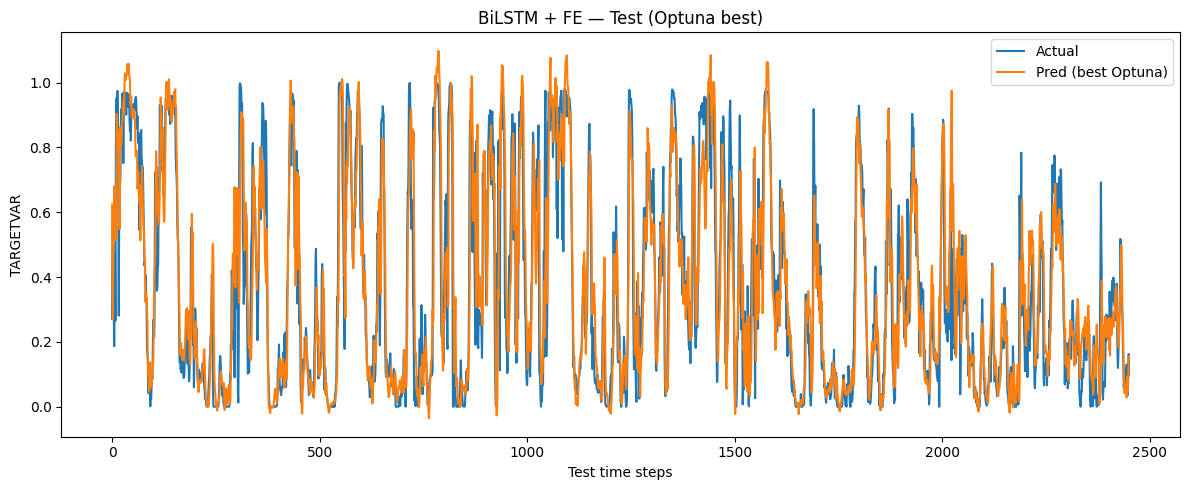

In [6]:
# tune_optuna_bilstm_wind.py
import argparse, json, math, random
from pathlib import Path

import numpy as np
import optuna
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt

# ======= Columns =======
TIME_COL   = "TIMESTAMP"
TARGET_COL = "TARGETVAR"
BASE_FEATS = ["U10", "V10", "U100", "V100"]

# ======= Fixed FE (same as your script) =======
LAGS_Y     = [1, 3, 6, 12, 24]
LAGS_SPEED = [1, 3, 6]
ROLLS_Y    = [6, 12, 24]

# ======= Splits =======
TRAIN_RATIO = 0.70
VAL_RATIO   = 0.15  # Test = rest (≈ 0.15)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ======= Repro =======
def set_seed(seed: int):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

# ======= FE =======
def add_engineered_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create new features out of the existing data 
    - Calculate the resultant wind speed and the resultant direction in sine and cosine terms
    - Caluclate the difference between the wind speeds at the two heights and get the angle difference too 
    - get the time values for seasonal and repititive features and convert it to sine and cos terms
    """
    out = df.copy()
    # wind speed & direction
    out["speed10"]  = np.sqrt(out["U10"]**2  + out["V10"]**2)
    out["speed100"] = np.sqrt(out["U100"]**2 + out["V100"]**2)
    dir10  = np.arctan2(out["V10"],  out["U10"])
    dir100 = np.arctan2(out["V100"], out["U100"])
    out["dir10_sin"], out["dir10_cos"]   = np.sin(dir10),  np.cos(dir10)
    out["dir100_sin"], out["dir100_cos"] = np.sin(dir100), np.cos(dir100)

    # shear & veer
    out["shear_speed"] = out["speed100"] - out["speed10"]
    veer = dir100 - dir10
    out["veer_sin"], out["veer_cos"] = np.sin(veer), np.cos(veer)

    # time features
    out["hour"] = out[TIME_COL].dt.hour
    out["day"]  = out[TIME_COL].dt.dayofyear
    out["hour_sin"] = np.sin(2*np.pi*out["hour"]/24.0)
    out["hour_cos"] = np.cos(2*np.pi*out["hour"]/24.0)
    out["day_sin"]  = np.sin(2*np.pi*out["day"]/366.0)
    out["day_cos"]  = np.cos(2*np.pi*out["day"]/366.0)

    # target lags (shifted)
    for L in LAGS_Y:
        out[f"y_lag{L}"] = out[TARGET_COL].shift(L)
    # rolling means of y (shift to avoid leakage)
    for W in ROLLS_Y:
        out[f"y_roll{W}"] = out[TARGET_COL].shift(1).rolling(W, min_periods=W).mean()
    # speed lags
    for L in LAGS_SPEED:
        out[f"speed10_lag{L}"]  = out["speed10"].shift(L)
        out[f"speed100_lag{L}"] = out["speed100"].shift(L)
    return out

def build_feat_list():
    """
    Create a  list of all the feature columns used to train the machine learning model
    Target values are also included in the dataset in specific time intervals.
    """
    return (
        BASE_FEATS +
        ["speed10","speed100","dir10_sin","dir10_cos","dir100_sin","dir100_cos",
         "shear_speed","veer_sin","veer_cos","hour_sin","hour_cos","day_sin","day_cos"] +
        [f"y_lag{L}" for L in LAGS_Y] +
        [f"y_roll{W}" for W in ROLLS_Y] +
        [f"speed10_lag{L}" for L in LAGS_SPEED] +
        [f"speed100_lag{L}" for L in LAGS_SPEED]
    )

# ======= Data I/O =======
def load_data(file_path: str, sheet: str) -> pd.DataFrame:
    "Read the dataset"
    df = pd.read_excel("WindPowerForecastingData.xlsx")
    df[TIME_COL] = pd.to_datetime(df[TIME_COL], infer_datetime_format=True, errors="coerce")
    df = df.sort_values(TIME_COL).reset_index(drop=True)
    return df

def smape(y_true, y_pred, eps=1e-8):
    "Symmetric mean absolute error. good for small scale data"
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return 100.0 * np.mean(2.0 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + eps))

# ======= Sequences / Dataset =======
def make_sequences(X, y, lookback):
    "create the lists of data for training and testing"
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i-lookback:i, :])
        ys.append(y[i, 0])
    return np.array(Xs, np.float32), np.array(ys, np.float32).reshape(-1,1)

class SeqDS(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

# ======= Model =======
class BiLSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, bidirectional=True):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers>1 else 0.0,
            bidirectional=bidirectional
        )
        out_size = hidden_size * (2 if bidirectional else 1)
        self.norm = nn.LayerNorm(out_size)
        self.head = nn.Sequential(
            nn.Linear(out_size, out_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(out_size, 1),
        )
    def forward(self, x):
        o, _ = self.lstm(x)
        last = o[:, -1, :]
        last = self.norm(last)
        return self.head(last)

# ======= Fold training (returns Val RMSE in original units) =======
def train_fold(Xtr, ytr, Xva, yva, params, max_epochs, es_patience, log_target, clip_norm):
    # scalers fit on train only
    xsc = StandardScaler().fit(Xtr)
    ysc = StandardScaler().fit(ytr)
    Xtr_s, ytr_s = xsc.transform(Xtr), ysc.transform(ytr)
    Xva_s, yva_s = xsc.transform(Xva), ysc.transform(yva)

    # sequences
    lookback = params["lookback"]
    Xtr_seq, ytr_seq = make_sequences(Xtr_s, ytr_s, lookback)
    Xva_seq, yva_seq = make_sequences(Xva_s, yva_s, lookback)

    if len(Xtr_seq) < 16 or len(Xva_seq) < 16:
        return float("inf"), None, None  # degenerate

    tr_loader = DataLoader(SeqDS(Xtr_seq, ytr_seq), batch_size=params["batch"], shuffle=True)
    va_loader = DataLoader(SeqDS(Xva_seq, yva_seq), batch_size=params["batch"], shuffle=False)

    model = BiLSTMRegressor(
        input_size=Xtr_seq.shape[-1],
        hidden_size=params["hidden"],
        num_layers=params["layers"],
        dropout=params["dropout"],
        bidirectional=params["bidir"]
    ).to(DEVICE)

    loss_fn = nn.SmoothL1Loss(beta=0.5)
    opt = torch.optim.Adam(model.parameters(), lr=params["lr"], weight_decay=params["wd"])
    # cosine warm restarts works well for seq models
    sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=10, T_mult=2, eta_min=1e-5)

    def inv_target(y_scaled):
        y = ysc.inverse_transform(y_scaled).ravel()
        if log_target:
            y = np.expm1(y)
        return y

    best = float("inf"); no_improve = 0; best_state = None
    for epoch in range(1, max_epochs+1):
        model.train()
        for xb, yb in tr_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            if clip_norm is not None:
                nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
            opt.step()
        sched.step(epoch-1)

        # compute Val RMSE in original units
        model.eval()
        preds_s, trues_s = [], []
        with torch.no_grad():
            for xb, yb in va_loader:
                pr = model(xb.to(DEVICE)).cpu().numpy()
                preds_s.append(pr); trues_s.append(yb.numpy())
        preds_s = np.vstack(preds_s); trues_s = np.vstack(trues_s)
        y_pred = inv_target(preds_s)
        y_true = inv_target(trues_s)
        rmse = math.sqrt(mean_squared_error(y_true, y_pred))

        if rmse < best - 1e-6:
            best = rmse; no_improve = 0; best_state = model.state_dict()
        else:
            no_improve += 1
            if no_improve >= es_patience:
                break

    return best, best_state, (xsc, ysc)

# ======= Walk-forward CV (on Train+Val region; Test held out) =======
def make_walkforward_indices(n_total, n_test):
    """
    Reserve last n_test for final Test.
    Create 3 CV folds on the preceding region with growing Train, small Val windows.
    """
    n_tv = n_total - n_test
    # folds: [0:0.60->0.75], [0:0.75->0.85], [0:0.85->0.95] of the train+val region
    cut1 = int(n_tv * 0.60); val1 = int(n_tv * 0.75)
    cut2 = int(n_tv * 0.75); val2 = int(n_tv * 0.85)
    cut3 = int(n_tv * 0.85); val3 = int(n_tv * 0.95)

    folds = [
        (0, cut1, cut1, val1),
        (0, cut2, cut2, val2),
        (0, cut3, cut3, val3),
    ]
    return folds, n_tv

# ======= Objective for Optuna =======
def objective(trial, df: pd.DataFrame, max_epochs: int, es_patience: int):
    # search space
    params = {
        "lookback": trial.suggest_categorical("lookback", [12, 24, 36]),
        "hidden":   trial.suggest_categorical("hidden",   [64, 128]),
        "layers":   trial.suggest_categorical("layers",   [1, 2, 3]),
        "dropout":  trial.suggest_categorical("dropout", [0.1,0.2,0.3]),
        "bidir":    trial.suggest_categorical("bidir",    [True, False]),
        "batch":    trial.suggest_categorical("batch",    [64, 128]),
        "lr":       trial.suggest_categorical("lr", [1e-4, 1e-3]),
        "wd":       trial.suggest_categorical("weight_decay", [0.0,1e-4, 1e-3]),
        "clip":     trial.suggest_categorical("clip_norm", [None, 0.5, 1.0]),
        "log_target": trial.suggest_categorical("log_target", [False, True]),
    }

    # feature engineering + target transform (depends on LOG_TARGET)
    dfe = add_engineered_features(df)
    if params["log_target"]:
        dfe["_y"] = np.log1p(dfe[TARGET_COL].clip(lower=0)).astype(np.float32)
    else:
        dfe["_y"] = dfe[TARGET_COL].astype(np.float32)
    dfe = dfe.dropna().reset_index(drop=True)

    feat_cols = build_feat_list()
    X_all = dfe[feat_cols].to_numpy(np.float32)
    y_all = dfe[["_y"]].to_numpy(np.float32)

    n_total = len(dfe)
    n_test  = int(len(dfe) * (1 - (TRAIN_RATIO + VAL_RATIO)))  # ≈ last 15% kept for final test
    folds, n_tv = make_walkforward_indices(n_total, n_test)

    fold_rmses = []
    for (tr_start, tr_end, va_start, va_end) in folds:
        Xtr = X_all[tr_start:tr_end]; ytr = y_all[tr_start:tr_end]
        Xva = X_all[va_start:va_end]; yva = y_all[va_start:va_end]
        rmse, _, _ = train_fold(Xtr, ytr, Xva, yva,
                                params=params,
                                max_epochs=max_epochs,
                                es_patience=es_patience,
                                log_target=params["log_target"],
                                clip_norm=params["clip"])
        fold_rmses.append(rmse)

    avg_rmse = float(np.mean(fold_rmses))
    trial.set_user_attr("fold_rmses", fold_rmses)
    return avg_rmse

# ======= Final train on Train+Val, test on Test =======
def final_fit_and_test(df, best_params, max_epochs, es_patience, outdir: Path):
    dfe = add_engineered_features(df)
    if best_params["log_target"]:
        dfe["_y"] = np.log1p(dfe[TARGET_COL].clip(lower=0)).astype(np.float32)
    else:
        dfe["_y"] = dfe[TARGET_COL].astype(np.float32)
    dfe = dfe.dropna().reset_index(drop=True)

    feat_cols = build_feat_list()
    X_all = dfe[feat_cols].to_numpy(np.float32)
    y_all = dfe[["_y"]].to_numpy(np.float32)

    n_total = len(dfe)
    n_test  = int(len(dfe) * (1 - (TRAIN_RATIO + VAL_RATIO)))
    n_tv    = n_total - n_test

    X_trval, y_trval = X_all[:n_tv], y_all[:n_tv]
    X_test,  y_test  = X_all[n_tv:], y_all[n_tv:]

    # scalers on Train+Val
    xsc = StandardScaler().fit(X_trval)
    ysc = StandardScaler().fit(y_trval)
    Xtrv_s, ytrv_s = xsc.transform(X_trval), ysc.transform(y_trval)
    Xte_s,  yte_s  = xsc.transform(X_test),  ysc.transform(y_test)

    # sequences
    lookback = best_params["lookback"]
    Xtrv_seq, ytrv_seq = make_sequences(Xtrv_s, ytrv_s, lookback)
    Xte_seq,  yte_seq  = make_sequences(Xte_s,  yte_s,  lookback)

    tr_loader = DataLoader(SeqDS(Xtrv_seq, ytrv_seq), batch_size=best_params["batch"], shuffle=True)
    te_loader = DataLoader(SeqDS(Xte_seq,  yte_seq ), batch_size=best_params["batch"], shuffle=False)

    model = BiLSTMRegressor(
        input_size=Xtrv_seq.shape[-1],
        hidden_size=best_params["hidden"],
        num_layers=best_params["layers"],
        dropout=best_params["dropout"],
        bidirectional=best_params["bidir"]
    ).to(DEVICE)
    loss_fn = nn.SmoothL1Loss(beta=0.5)
    opt = torch.optim.Adam(model.parameters(), lr=best_params["lr"], weight_decay=best_params["wd"])
    sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=10, T_mult=2, eta_min=1e-5)

    best = float("inf"); no_improve = 0; best_state = None
    for epoch in range(1, max_epochs+1):
        model.train()
        for xb, yb in tr_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            if best_params["clip"] is not None:
                nn.utils.clip_grad_norm_(model.parameters(), best_params["clip"])
            opt.step()
        sched.step(epoch-1)

        # quick es on a random slice of tr_loader (optional)
        # here we skip extra val, and just run full epochs for stability

    # Evaluate on TEST in original units
    def inv_target(y_scaled):
        ys = ysc.inverse_transform(y_scaled).ravel()
        if best_params["log_target"]:
            ys = np.expm1(ys)
        return ys

    model.eval()
    preds_s, trues_s = [], []
    with torch.no_grad():
        for xb, yb in te_loader:
            pr = model(xb.to(DEVICE)).cpu().numpy()
            preds_s.append(pr); trues_s.append(yb.numpy())
    preds_s = np.vstack(preds_s); trues_s = np.vstack(trues_s)
    y_pred = inv_target(preds_s)
    y_true = inv_target(trues_s)

    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    smp  = smape(y_true, y_pred)

    # Save artifacts
    torch.save(model.state_dict(), outdir / "biLSTM/bilstm_optuna_best.pt")
    joblib.dump(xsc, outdir / "biLSTM/x_scaler_optuna.pkl")
    joblib.dump(ysc, outdir / "biLSTM/y_scaler_optuna.pkl")
    with open(outdir / "best_params.json", "w") as f:
        json.dump(best_params, f, indent=2)

    plt.figure(figsize=(12,5))
    plt.plot(y_true, label="Actual")
    plt.plot(y_pred, label="Pred (best Optuna)")
    plt.title("BiLSTM + FE — Test (Optuna best)")
    plt.xlabel("Test time steps"); plt.ylabel(TARGET_COL)
    plt.legend(); plt.tight_layout()
    plt.savefig(outdir / "biLSTM/test_plot_optuna.png", dpi=150)

    print("\n==== TEST (Optuna best) ====")
    print(f"RMSE : {rmse:.6f}\nMAE  : {mae:.6f}\nR^2  : {r2:.6f}\nsMAPE: {smp:.2f}%")
    print(f"Saved to: {outdir.resolve()}")

# ======= helper metrics used above =======
def mean_squared_error(y_true, y_pred):
    return np.mean((np.asarray(y_true) - np.asarray(y_pred))**2)
# ======= CLI =======

ap = argparse.ArgumentParser()
ap.add_argument("--file",   type=str, required=True)
ap.add_argument("--sheet",  type=str, default="WindPowerForecastingData")
ap.add_argument("--trials", type=int, default=15)
ap.add_argument("--timeout", type=int, default=None, help="Seconds budget (optional)")
ap.add_argument("--epochs", type=int, default=80)
ap.add_argument("--patience", type=int, default=12)
ap.add_argument("--seed",  type=int, default=42)
ap.add_argument("--outdir", type=str, default=".")
args = ap.parse_args()

set_seed(args.seed)
outdir = Path(args.outdir); outdir.mkdir(parents=True, exist_ok=True)

df = load_data(args.file, args.sheet)

study = optuna.create_study(direction="minimize")
study.optimize(
    lambda tr: objective(tr, df=df, max_epochs=args.epochs, es_patience=args.patience),
    n_trials=args.trials,
    timeout=args.timeout,
    show_progress_bar=True,
    gc_after_trial=True
    )

print("\n==== OPTUNA BEST ====")
print("Value (avg Val RMSE):", study.best_value)
print("Params:", study.best_params)
    # coerce types (optuna may return None for clip_norm)
best_params = {
    "lookback": study.best_params["lookback"],
    "hidden":   study.best_params["hidden"],
    "layers":   study.best_params["layers"],
    "dropout":  float(study.best_params["dropout"]),
    "bidir":    bool(study.best_params["bidir"]),
    "batch":    study.best_params["batch"],
    "lr":       float(study.best_params["lr"]),
    "wd":       float(study.best_params["weight_decay"]),
    "clip":     study.best_params["clip_norm"] if study.best_params["clip_norm"] is not None else None,
    "log_target": bool(study.best_params["log_target"]),
    }

    # Final train on Train+Val, test on Test
final_fit_and_test(df, best_params, args.epochs, args.patience, outdir)




